In [1]:
import os
import sys
from dotenv import load_dotenv
import yaml

load_dotenv()
DVUTILS_LOCAL_CLONE_PATH = os.environ.get("DVUTILS_LOCAL_CLONE_PATH")
sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)

from utils_io import *

Info: Found credentials at: /Users/jcroff/Library/CloudStorage/Box-Box/dvutils-creds-jcroff.json


## Define Parameters

In [2]:
## Set the PCA Layers configuration file: PCA Geographies and PCA Types
yaml_file = 'pca-layers.yml'

## Create ArcGIS Client
client = create_arcgis_client()

Admin ArcGIS client created


## Create Functions

In [3]:
def simplify_geoms(gdf):
    """Simplify and clean Geometries by applying dissolve, explode,
    simplify and repair_geometry functions
    """
    print("Checking geometry validity and repairing geometries prior to dissolve/explode steps") ## JC: Added print statement
    ## Check/Repair Geometries
    gdf = repair_geometry(gdf.query("geometry.notnull()")) ## JC: Added repair step prior to dissolve; 
                                                           ## invalid geometries/ ring order issues will cause dissolve to fill holes incorrectly. 
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")
    ## Convert Multipart features to Single part
    gdf = gdf.dissolve(by=None).reset_index(drop=True)
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
    ## Repair Geometries
    gdf = repair_geometry(gdf.query("geometry.notnull()"))
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")

    return gdf


def create_footprint(gdf, flag_name, dist=False):
    """Create Area Footprint from GeoDataframe and assign Flag Name
    to Column
    """
    ## Simplify Dataset
    gdf = gdf[["geometry"]].copy()
    gdf = simplify_geoms(gdf)
    ## Set Area Name
    gdf[flag_name] = 1

    return gdf


def create_footprints_for_dict(input_dict, flag_name):
    """Iterate through Dictionary object and create area footprints
    by applying the create_footprint function
    """
    for k, v in input_dict.items():
        print(f"Creating Footprint for dataset: {k}")
        try:
            data_key = "data" if "data" in v else "data_load"
            print(f"Using: {data_key}")
            v["footprint"] = create_footprint(v[data_key], v[flag_name])
            v["footprint"].plot()
            print("Creation of Footprint completed\n")
        except:
            print("Creation of Footprint failed!\n")

In [4]:
def assign_footprint(
                gdf_base,
                gdf_over,
                flag_name,
                gdf_base_id="gdf_id",
                return_share=True
                ):
    """Given an Input Geodataframe, runs Spatial Overlay
    to p10 Parcels and returns Parcel Assignment crosswalk
    """
    ## Check for gdf_id or create
    if (gdf_base_id == 'gdf_id') and (not gdf_base_id in gdf_base.columns):
        print('Creating gdf_id')
        gdf_base.reset_index(drop=True, inplace=True)
        # gdf_base['gdf_id'] = gdf_base.index
        gdf_base["gdf_id"] = 1 + gdf_base.index ## JC: Changed to 1-based index
    ## Create Base GeoDataframe to Input GeoDataframe correspondence
    print('Creating Base GeoDataframe to Input GeoDataframe correspondence')
    gdf_over_corresp = geo_assign_fields(
        id_df=gdf_base[[gdf_base_id, 'geometry']],
        id_field=gdf_base_id,
        overlay_df=gdf_over,
        overlay_fields=[flag_name],
        return_intersection_area=return_share,
    )
    ## Merge p10 Parcels GeoDataframe to Input GeoDataframe using correspondence,
    ## return Dataframe
    gdf_base_fields = [i for i in gdf_base.columns if i != "geometry"]
    if return_share:
        if (not 'area_sq_m' in gdf_base.columns):
            print('Creating area_sq_m')
            gdf_base['area_sq_m'] = gdf_base.geometry.area
            gdf_base_fields.append("area_sq_m")
    base_over = pd.merge(gdf_base[gdf_base_fields], gdf_over_corresp, on=gdf_base_id, how="left")
    if return_share:
        intersect_area_col = f"{flag_name}_intersect_sq_m"
        share_pct_col = f"{flag_name}_share_pct"
        base_over.rename(columns={"intersection_sq_m": intersect_area_col}, inplace=True)
        base_over[share_pct_col] = base_over[intersect_area_col] / base_over["area_sq_m"]

    return base_over


def assign_footprints_from_dictionary(base_dict, overlay_dict, flag_col):
    """
    Assigns a footprint flag to base_dict for each item in the overlay_dict, based on flag_name.
    """
    for pca_type, type_att in overlay_dict.items():
        try:
            print(f'Dataset {pca_type}: Starting Assignment of Footprint')
            flag_name = type_att[flag_col]
            type_att['assignment'] = assign_footprint(
                # gdf_base=base_dict['data_load'],
                gdf_base=base_dict['data'], ## JC: Changed to use 'data' instead of 'data_load'
                gdf_over=type_att['footprint'],
                flag_name = flag_name
                )
            print(f'Dataset {pca_type}: Assignment of Footprint complete\n')
        except:
            print(f'Dataset {pca_type}: Assignment of Footprint failed!\n')
            pass

## Load PCA Layers definitions from YAML

In [5]:
## Load PCA Geographies from YAML
with open(yaml_file, 'r') as file:
    pca_geo = yaml.safe_load(file)['pca_geo']
print(pca_geo)

## Load PCA Types from YAML
with open(yaml_file, 'r') as file:
    pca_types = yaml.safe_load(file)['pca_types']
print([i for i in pca_types.keys()])

## Load UGB from YAML
with open(yaml_file, 'r') as file:
    ugb = yaml.safe_load(file)['ugb']
print(ugb)

{'name': 'PCA Geographies', 'agol': 'https://www.arcgis.com/home/item.html?id=8f4a98b1bb32402db22ba7379ea062a9', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/PBA50_PCA_Polygons/FeatureServer/2'}
['natural_land', 'working_land', 'urban_greening', 'recreation', 'climate_adaptation']
{'flag': 'ugb', 'name': 'EN4_Urban_Growth_Boundary', 'agol': 'https://mtc.maps.arcgis.com/home/item.html?id=9e16c1e49bcf40f5817d26a7684e1ad4', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/EN4_Urban_Growth_Boundary/FeatureServer/0'}


## Load PCA Layers from AGOL Datasets

Breaking feature service layer IDs into 1 chunks


<Axes: >

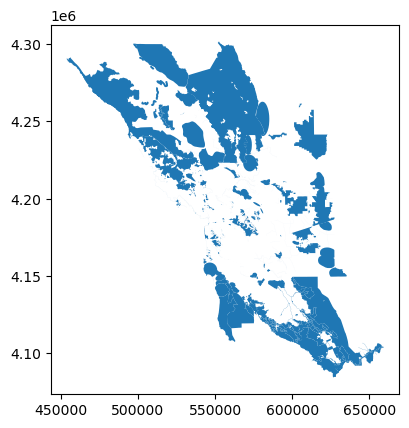

In [6]:
## Load PCA Geographies
## Pull GeoTable from AGOL as GeoDataframe
pca_geo['data_load'] = pull_geotable_agol(pca_geo['url'], client=client)

pca_geo['data'] = pca_geo['data_load'].copy()
pca_geo['data'].reset_index(drop=True, inplace=True)
pca_geo['data']['gdf_id'] = 1 + pca_geo['data'].index

pca_geo['data'].plot()

natural_land
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Natural_Land_PCA_Eligibility_v0a/FeatureServer/0
Loading data for natural_land
Breaking feature service layer IDs into 3 chunks
Data loaded successfully

working_land
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Working_Land_PCA_Eligibility/FeatureServer/225
Loading data for working_land
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

urban_greening
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Urban_Greening_PCA_Eligibility/FeatureServer/226
Loading data for urban_greening
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

recreation
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Regional_Recreation_PCA_Eligibility/FeatureServer/227
Loading data for recreation
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

climate_adaptation
https://services3.arcgis.com/i2dkYWmb4wHvY

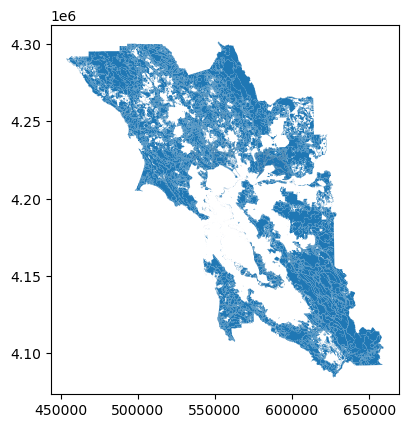

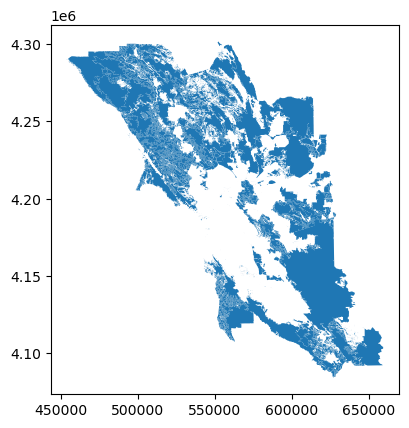

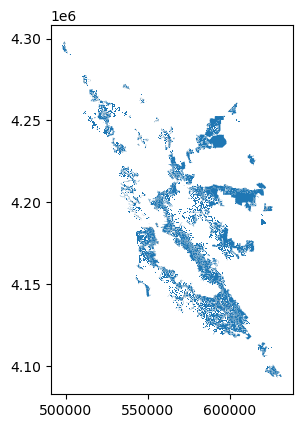

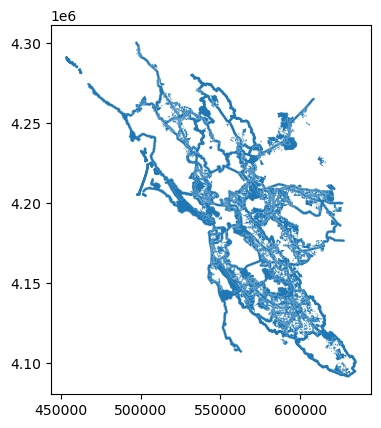

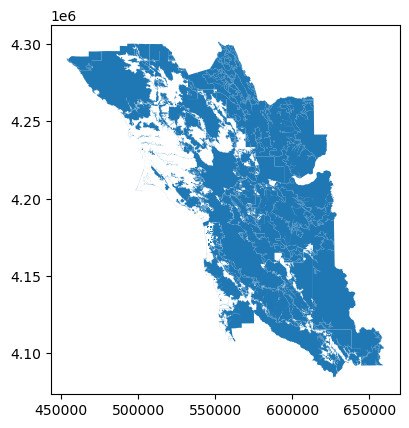

In [7]:
## Load PCA types
for i in pca_types.keys():
    print(i)
    print(pca_types[i]['url'])
    try:
        print(f"Loading data for {i}")
        ## Pull GeoTable from AGOL as GeoDataframe
        pca_types[i]['data_load'] = pull_geotable_agol(pca_types[i]['url'], client=client)
        pca_types[i]['data_load'].plot()
        print("Data loaded successfully\n")
    except:
        print(f"Failed to load data for {i}!\n")


Breaking feature service layer IDs into 6 chunks


<Axes: >

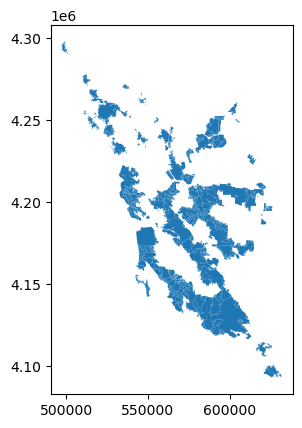

In [8]:
## Load UGB
## Pull GeoTable from AGOL as GeoDataframe
ugb['data_load'] = pull_geotable_agol(ugb['url'], client=client)

ugb['data'] = ugb['data_load'].copy()
ugb['data'].reset_index(drop=True, inplace=True)
ugb['data']['ugb_geo_id'] = 1 + ugb['data'].index

ugb['data'].plot()

## Flag #1 PCA Geographies to PCA Types

### Create Footprints for PCA Types

Creating Footprint for dataset: natural_land
Using: data_load
Checking geometry validity and repairing geometries prior to dissolve/explode steps
Geodataframe contains invalid geometry, starting geometry repair process...

Valid Geometry                                               484
Ring Self-intersection[652010.510268478 4104912.65930232]      1
Ring Self-intersection[542393.870429619 4247315.79755137]      1
Ring Self-intersection[652702.619596729 4113625.67785828]      1
Ring Self-intersection[635023.27625245 4134431.71916091]       1
                                                            ... 
Ring Self-intersection[620155.312239087 4120944.09540752]      1
Ring Self-intersection[582122.188820239 4157017.95564342]      1
Ring Self-intersection[512423.050990943 4268803.28799481]      1
Ring Self-intersection[537435.532889743 4197189.62545162]      1
Ring Self-intersection[537054.001227644 4228261.94411401]      1
Name: count, Length: 82, dtype: int64

Geometry repair complet

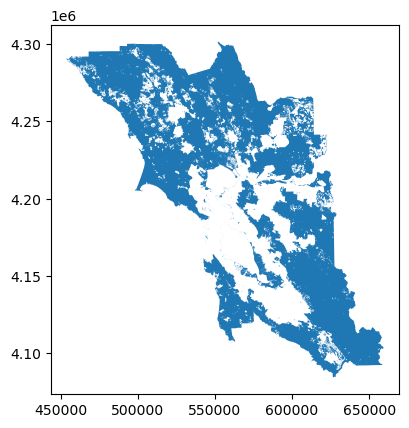

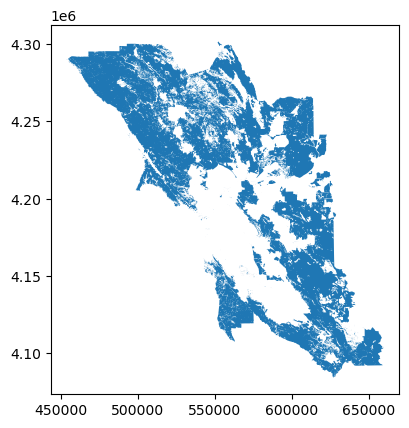

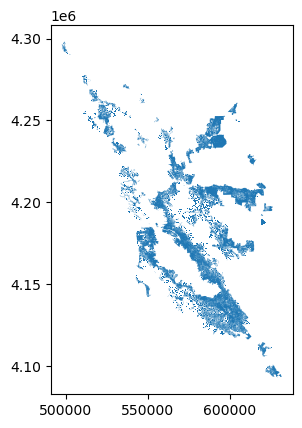

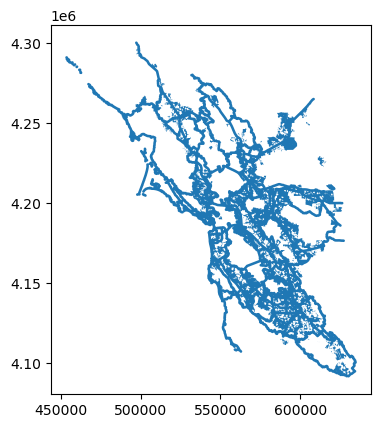

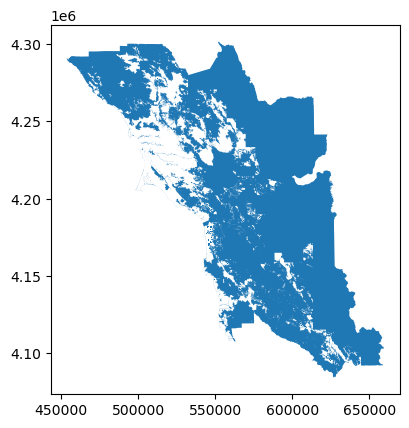

In [9]:
create_footprints_for_dict(pca_types, 'flag')

### Assign PCA Type Footprints to PCA Geographies

In [10]:
## JC: Tests for create_footprints functions
# rec_df = pca_types["recreation"]["data_load"]
# rec_df_rep = repair_geometry(rec_df.query("geometry.notnull()"))
# rec_df_diss = rec_df_rep.dissolve()

In [11]:
assign_footprints_from_dictionary(pca_geo, pca_types, 'flag')

Dataset natural_land: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 9.4232 seconds
Creating area_sq_m
Dataset natural_land: Assignment of Footprint complete

Dataset working_land: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 126 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 11.4287 seconds
Dataset working_land: Assignment of Footprint complete

Dataset urban_greening: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 32.1237 seconds
Dataset urban_greening: Assignment of Footprint complete

Dataset recreation: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence


/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 156 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


took 6.9072 seconds
Dataset recreation: Assignment of Footprint complete

Dataset climate_adaptation: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
took 46.1934 seconds
Dataset climate_adaptation: Assignment of Footprint complete



/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 136 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
for pca_type, type_att in pca_types.items():
    try:
        print('Displaying Assignment of Footprint for PCA Type:', pca_type)
        display(type_att['assignment'].sample(3))
    except:
        print(f'Display of Assignment of Footprint for PCA Type {pca_type} failed!')

Displaying Assignment of Footprint for PCA Type: natural_land


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1nl,base_sq_m,1nl_intersect_sq_m,area_share,1nl_share_pct
18,19,6041,MR11,Marin County Parks and Open Space Department,Tiburon Ridge Lands,566.623949,1,0,0,0,...,566.623949,2.293046e+06,14558.382550,19,2.293034e+06,1.0,2.293034e+06,3.334215e+03,0.001454,0.001454
199,200,6075,SF111,City and County of San Francisco,Excelsior/OMI Trail Connections,0.472791,0,0,1,1,...,0.472791,1.913319e+03,6282.032961,200,1.913322e+03,NaN,1.913322e+03,NaN,NaN,NaN
159,160,6095,SL5,Solano County,Suisun Valley,9106.676522,1,1,1,0,...,9106.676522,3.685341e+07,37291.996347,160,3.685315e+07,1.0,3.685315e+07,3.239675e+07,0.879077,0.879077


Displaying Assignment of Footprint for PCA Type: working_land


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1wl,base_sq_m,1wl_intersect_sq_m,area_share,1wl_share_pct
182,183,6055,NP5,Napa County Regional Park and Open Space District,Southern Mountains - Skyline Park to Newell Pr...,18644.471077,1,0,0,1,...,18644.471077,7.545150e+07,61717.317383,183,7.545113e+07,1.0,7.545113e+07,6.229957e+07,0.825694,0.825694
169,170,6085,SC33,Midpeninsula Regional Open Space District,Saratoga-to-the-Sea,229.931830,1,0,0,1,...,229.931830,9.305011e+05,7523.329429,170,9.305073e+05,1.0,9.305073e+05,9.240193e+05,0.993027,0.993027
140,141,6085,SC53,Santa Clara Valley Open Space Authority,Santa Cruz Mountains East,51851.364120,1,1,0,1,...,51851.364120,2.098350e+08,177503.424077,141,2.165944e+08,1.0,2.165944e+08,1.838154e+08,0.848662,0.848662


Displaying Assignment of Footprint for PCA Type: urban_greening


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1ug,base_sq_m,1ug_intersect_sq_m,area_share,1ug_share_pct
90,91,6095,MULTI1,San Francisco Bay Trail Project,San Francisco Bay Trail - Bay Area Ridge Trail,289.196313,1,0,0,0,...,289.196313,1.170336e+06,253793.228278,91,1.687242e+06,1.0,1.687242e+06,498477.277955,0.295439,0.295439
58,59,6097,SN14,Sonoma County Agricultural Preservation and Op...,Sonoma County Gateway,2775.902447,1,0,0,0,...,2775.902447,1.123368e+07,12862.701845,59,1.123365e+07,NaN,1.123365e+07,NaN,NaN,NaN
113,114,6081,SM16,Midpeninsula Regional Open Space District,South Skyline,5443.126805,1,0,0,1,...,5443.126805,2.202755e+07,27187.704924,114,2.202758e+07,NaN,2.202758e+07,NaN,NaN,NaN


Displaying Assignment of Footprint for PCA Type: recreation


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1r,base_sq_m,1r_intersect_sq_m,area_share,1r_share_pct
191,192,6075,SF109,City and County of San Francisco,Northern Waterfront,129.023227,0,0,0,1,...,129.023227,5.221385e+05,25950.464222,192,5.221356e+05,1.0,5.221356e+05,5.221356e+05,1.000000,1.000000
163,164,6055,NP4,Napa County Regional Park and Open Space District,Palisades - Mount Saint Helena to Angwin,17883.976733,1,0,0,1,...,17883.976733,7.237389e+07,30494.784664,164,7.237390e+07,1.0,7.237390e+07,2.763215e+07,0.381797,0.381797
94,95,6081,MULTI4,"San Mateo County, on behalf of the State Coast...",California Coastal Trail,205.277792,0,0,0,1,...,205.277792,8.307297e+05,135667.711481,95,1.241529e+06,1.0,1.241529e+06,1.036130e+06,0.834560,0.834560


Displaying Assignment of Footprint for PCA Type: climate_adaptation


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1ca,base_sq_m,1ca_intersect_sq_m,area_share,1ca_share_pct
102,103,6013,MULTI5,"San Mateo County, on behalf of the State Coast...",San Francisco Bay Area Water Trail,1.951756,0,0,0,1,...,1.951756,7.898475e+03,1300.628543,103,7.898464e+03,1,7.898464e+03,6.689259e+03,0.846906,0.846906
152,153,6001,AL31,City of Oakland,Oakland Priority Creek Trails,480.414061,1,0,1,1,...,480.414061,1.944167e+06,32429.443788,153,1.944168e+06,1,1.944168e+06,1.789847e+06,0.920624,0.920624
138,139,6085,SC63,Santa Clara Valley Open Space Authority,Pacheco Agriculture,1140.376968,0,1,0,0,...,1140.376968,4.614942e+06,20021.511917,139,4.614907e+06,1,4.614907e+06,2.777168e+06,0.601782,0.601782


## Integrate Assignments of PCA Types to single Assignment file

In [13]:
data_key = "data" if "data" in pca_geo.keys() else "data_load"
pca_geo['assignment'] = pca_geo[data_key].drop(columns=['geometry'])
## Merge PCA Geographies to PCA Types Assignments 
for pca_type, type_att in pca_types.items():
    try:
        flag = type_att['flag']
        cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
        pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            type_att['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
        print(f'Assignment of Footprint for PCA Type {pca_type} completed\n')
    except:
        print(f'Assignment of Footprint for PCA Type {pca_type} failed!\n')

Assignment of Footprint for PCA Type natural_land completed

Assignment of Footprint for PCA Type working_land completed

Assignment of Footprint for PCA Type urban_greening completed

Assignment of Footprint for PCA Type recreation completed

Assignment of Footprint for PCA Type climate_adaptation completed



## Flag #2 PCA to UGB

### Create Footprint for UGB

Creating Footprint for dataset: EN4_Urban_Growth_Boundary
Using: data
Checking geometry validity and repairing geometries prior to dissolve/explode steps
Geodataframe contains invalid geometry, starting geometry repair process...

Valid Geometry                                               977
Ring Self-intersection[593030.151624766 4183232.51093502]      2
Nested shells[535361.251326685 4221042.0417289]                2
Nested shells[602122.748324892 4208580.17736659]               2
Nested shells[596629.463950304 4210345.37048695]               2
                                                            ... 
Nested shells[561494.600771001 4205905.4560161]                1
Nested shells[591582.593131713 4141530.89013723]               1
Nested shells[603946.17803018 4137689.87884512]                1
Nested shells[574593.972714385 4138226.15783478]               1
Nested shells[574299.492449782 4216921.91911037]               1
Name: count, Length: 147, dtype: int64

Geometry repai

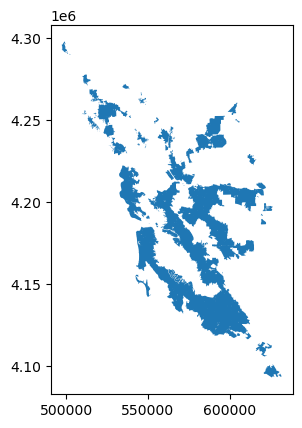

In [14]:
print(f"Creating Footprint for dataset: {ugb['name']}")
data_key = "data" if "data" in ugb.keys() else "data_load"
print(f"Using: {data_key}")
ugb["footprint"] = create_footprint(ugb[data_key], ugb['flag'])
ugb["footprint"].plot()
print("Creation of Footprint completed\n")

### Assign UGB Footprint to PCA Geographies

In [15]:
print(f"Dataset {ugb['name']}: Starting Assignment of Footprint")
data_key = "data" if "data" in pca_geo.keys() else "data_load"
print(f"Using: {data_key}")
flag_name = ugb['flag']
ugb['assignment'] = assign_footprint(
    gdf_base=pca_geo[data_key],
    gdf_over=ugb['footprint'],
    flag_name = flag_name
    )
print(f"Dataset {ugb['name']}: Assignment of Footprint complete\n")

Dataset EN4_Urban_Growth_Boundary: Starting Assignment of Footprint
Using: data
Creating Base GeoDataframe to Input GeoDataframe correspondence
took 3.191 seconds
Dataset EN4_Urban_Growth_Boundary: Assignment of Footprint complete



/Users/jcroff/Documents/GitHub/dvutils/utils_analytics.py:2569: UserWarning: `keep_geom_type=True` in overlay resulted in 598 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  join_df = gpd.overlay(id_df, overlay_df, how="intersection")
/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
ugb['assignment'].sample(3).T

,11,104,205
OBJECTID,12,105,206
fipco,6041,6081,6013
joinkey,MR4,MULTI5,CC101
lead,Marin Agricultural Land Trust,"San Mateo County, on behalf of the State Coast...",City of Pittsburg
name,Marin County Agricultural Lands,San Francisco Bay Area Water Trail,Northwest Waterfront
acres,91106.64861,1.492519,176.801185
typenl,0,0,0
typeal,1,0,0
typeug,0,0,0
typerr,0,1,1


## Integrate Assignments of UGB to single Assignment file

In [17]:
## Assign UGB Footprint to PCA Geographies
## Assignment #1 should be run first
flag = ugb['flag']
cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            ugb['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
print(f"Assignment of Footprint for {ugb['flag']} completed")

Assignment of Footprint for ugb completed


### Check samples from Integrated Assignments table

In [18]:
pca_geo['assignment'].sample(3).T

,192,75,36
OBJECTID,193,76,37
fipco,6085,6097,6001
joinkey,SC101,SN6,MULTI6
lead,City of Palo Alto,Save-the-Redwoods League,East Bay Regional Park District (EBRPD)
name,Palo Alto Baylands,Coastal Sonoma to Armstrong Redwoods,Bethany Reservoir Area
acres,2627.365457,169991.588584,8386.764712
typenl,1,1,1
typeal,0,0,0
typeug,0,0,0
typerr,1,0,1


## Export Integrated Assignments #1 and #2 as Table

In [19]:
col_order = ['gdf_id'] + [c for c in pca_geo['assignment'].columns if c != 'gdf_id']
pca_geo['assignment'][col_order].fillna(0).to_csv('pca_type_assignment.csv', index=False)

## Flag #3 PCA to PCA

In [20]:
def overlay_surface_percentage_matrix(gdf, id_column='gdf_id', how='intersection'):
    """
    Creates a matrix of overlay surface percentages for each pair of features in the GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The input GeoDataFrame.
    id_column (str): The name of the column with unique numeric identifiers.
    how (str): The type of overlay operation (default is 'intersection').
    
    Returns:
    matrix (DataFrame): A DataFrame where each cell (i, j) contains the percentage of the surface area of feature i
                        that is overlapped by feature j.
    """
    if id_column not in gdf.columns:
        raise ValueError(f"GeoDataFrame must contain a column named '{id_column}'")

    ids = gdf[id_column].values
    matrix = pd.DataFrame(index=ids, columns=ids, dtype=float)
    
    for i, id_i in enumerate(ids):
        print(f"Processing feature {i + 1} of {len(ids)}")
        feature_i = gdf[gdf[id_column] == id_i]
        for j, id_j in enumerate(ids):
            if id_i == id_j:
                # The percentage of overlay with itself is 100%
                matrix.at[id_i, id_j] = 100.0
            else:
                feature_j = gdf[gdf[id_column] == id_j]
                overlay_result = gpd.overlay(feature_i, feature_j, how=how, keep_geom_type=True)
                
                if not overlay_result.empty:
                    # Calculate the percentage of the surface area of feature i that is overlapped by feature j
                    area_i = feature_i.geometry.area.values[0]
                    area_overlay = overlay_result.geometry.area.sum()
                    percentage_overlay = (area_overlay / area_i) * 100
                else:
                    percentage_overlay = 0.0
                
                matrix.at[id_i, id_j] = percentage_overlay
    
    return matrix

In [21]:
# Perform the overlay matrix operation
pca_geo['matrix'] = overlay_surface_percentage_matrix(pca_geo['data'], id_column='gdf_id', how='intersection')


Processing feature 1 of 208
Processing feature 2 of 208
Processing feature 3 of 208
Processing feature 4 of 208
Processing feature 5 of 208
Processing feature 6 of 208
Processing feature 7 of 208
Processing feature 8 of 208
Processing feature 9 of 208
Processing feature 10 of 208
Processing feature 11 of 208
Processing feature 12 of 208
Processing feature 13 of 208
Processing feature 14 of 208
Processing feature 15 of 208
Processing feature 16 of 208
Processing feature 17 of 208
Processing feature 18 of 208
Processing feature 19 of 208
Processing feature 20 of 208
Processing feature 21 of 208
Processing feature 22 of 208
Processing feature 23 of 208
Processing feature 24 of 208
Processing feature 25 of 208
Processing feature 26 of 208
Processing feature 27 of 208
Processing feature 28 of 208
Processing feature 29 of 208
Processing feature 30 of 208
Processing feature 31 of 208
Processing feature 32 of 208
Processing feature 33 of 208
Processing feature 34 of 208
Processing feature 35 o

/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 72 of 208
Processing feature 73 of 208
Processing feature 74 of 208
Processing feature 75 of 208
Processing feature 76 of 208
Processing feature 77 of 208
Processing feature 78 of 208
Processing feature 79 of 208
Processing feature 80 of 208
Processing feature 81 of 208
Processing feature 82 of 208
Processing feature 83 of 208
Processing feature 84 of 208
Processing feature 85 of 208
Processing feature 86 of 208
Processing feature 87 of 208
Processing feature 88 of 208
Processing feature 89 of 208
Processing feature 90 of 208
Processing feature 91 of 208
Processing feature 92 of 208
Processing feature 93 of 208
Processing feature 94 of 208
Processing feature 95 of 208
Processing feature 96 of 208
Processing feature 97 of 208
Processing feature 98 of 208
Processing feature 99 of 208
Processing feature 100 of 208
Processing feature 101 of 208
Processing feature 102 of 208
Processing feature 103 of 208
Processing feature 104 of 208
Processing feature 105 of 208
Processi

/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 170 of 208
Processing feature 171 of 208


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 172 of 208
Processing feature 173 of 208


/Users/jcroff/anaconda3/envs/esri_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 174 of 208
Processing feature 175 of 208
Processing feature 176 of 208
Processing feature 177 of 208
Processing feature 178 of 208
Processing feature 179 of 208
Processing feature 180 of 208
Processing feature 181 of 208
Processing feature 182 of 208
Processing feature 183 of 208
Processing feature 184 of 208
Processing feature 185 of 208
Processing feature 186 of 208
Processing feature 187 of 208
Processing feature 188 of 208
Processing feature 189 of 208
Processing feature 190 of 208
Processing feature 191 of 208
Processing feature 192 of 208
Processing feature 193 of 208
Processing feature 194 of 208
Processing feature 195 of 208
Processing feature 196 of 208
Processing feature 197 of 208
Processing feature 198 of 208
Processing feature 199 of 208
Processing feature 200 of 208
Processing feature 201 of 208
Processing feature 202 of 208
Processing feature 203 of 208
Processing feature 204 of 208
Processing feature 205 of 208
Processing feature 206 of 208
Processing

### Export PCA to PCA Overlay Matrix

In [22]:
pca_geo['matrix'].fillna(0).to_csv('pca_matrix.csv', index=True)